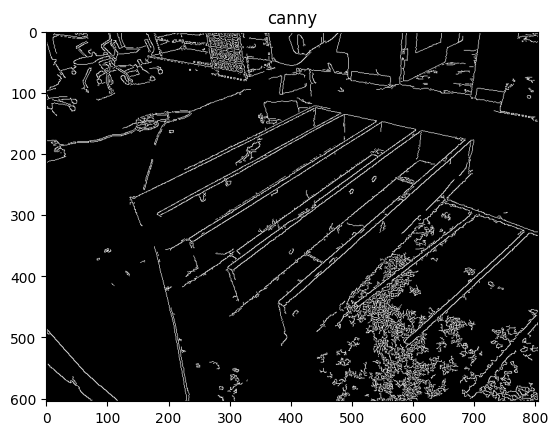

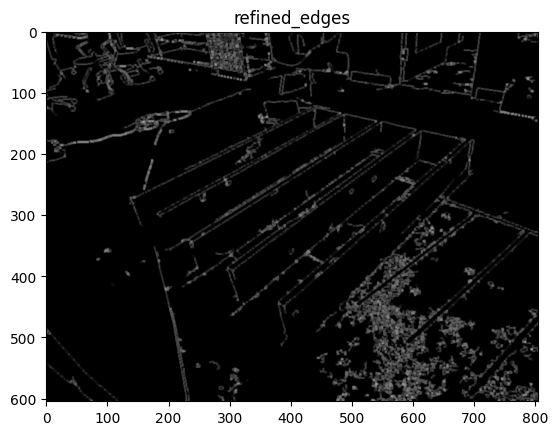

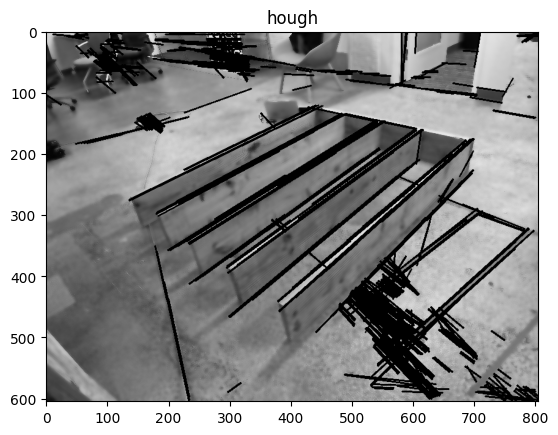

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('pics/IMG_1487.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (0, 0), fx=0.2, fy=0.2)
bilateral = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

# Apply edge detection
edges = cv2.Canny(bilateral, 50, 150)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.title('canny')
plt.show()

edges = cv2.GaussianBlur(edges, (3, 3), 0)
# plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
# plt.title('canny')
# plt.show()
# Morphological operations
kernel = np.ones((3, 3), np.uint8)
refined_edges = cv2.erode(edges, kernel, iterations=1)
refined_edges = cv2.dilate(refined_edges, kernel, iterations=1)

plt.imshow(cv2.cvtColor(refined_edges, cv2.COLOR_BGR2RGB))
plt.title('refined_edges')
plt.show()

# Detect lines using HoughLinesP
lines = cv2.HoughLinesP(edges, 1, 2*np.pi/180, threshold=200, minLineLength=20, maxLineGap=5)

# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(bilateral, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB))
plt.title('hough')
plt.show()

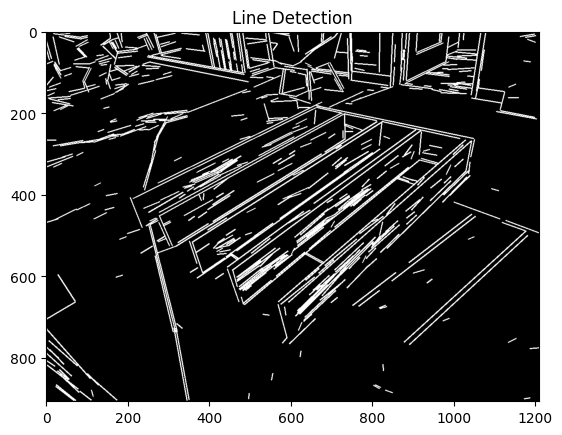

In [32]:
import pyelsed

def merge_lines(lines, distance_threshold=5):
    """Merge collinear lines into single line segments."""
    if lines is None:
        return []

    merged_lines = []
    # lines = np.array([line[0] for line in lines])  # Flatten the lines array

    for line in lines:
        x1, y1, x2, y2 = line
        merged = False
        
        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line
            
            # Calculate distance between line endpoints
            dist1 = np.linalg.norm([x1 - mx1, y1 - my1])
            dist2 = np.linalg.norm([x2 - mx2, y2 - my2])
            dist3 = np.linalg.norm([x1 - mx2, y1 - my2])
            dist4 = np.linalg.norm([x2 - mx1, y2 - my1])

            # Check if the lines are collinear and close
            if dist1 < distance_threshold or dist2 < distance_threshold or dist3 < distance_threshold or dist4 < distance_threshold:
                # Merge lines by averaging the endpoints
                new_x1 = min(x1, mx1)
                new_y1 = min(y1, my1)
                new_x2 = max(x2, mx2)
                new_y2 = max(y2, my2)
                merged_lines.remove(merged_line)
                merged_lines.append((new_x1, new_y1, new_x2, new_y2))
                merged = True
                break
        
        if not merged:
            # only add to list if line is longer than 10 pixels
            if np.linalg.norm([x1 - x2, y1 - y2]) > 50:
                merged_lines.append((x1, y1, x2, y2))

    return merged_lines

frame = cv2.imread('IMG_1487.jpg')
# frame should be a black images the same size as the original image
    
# Convert to grayscale for processing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# resize the image by half
gray = cv2.resize(gray, (0, 0), fx=0.3, fy=0.3)
# add gaussian blur
gray = cv2.GaussianBlur(gray, (5, 5), 0)

segments, scores = pyelsed.detect(gray)
# merged_segments = merge_lines(segments, distance_threshold=5)

elsed_image = np.zeros_like(gray)

if segments is not None:
    for x1, y1, x2, y2 in segments:
        if np.linalg.norm([x1 - x2, y1 - y2]) > 10:
            cv2.line(elsed_image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Green lines
    


# Display the result
plt.imshow(cv2.cvtColor(elsed_image, cv2.COLOR_BGR2RGB))
plt.title('Line Detection')
plt.show()
